In [2]:
import torch
import sys
sys.path.append("/nfs/norasys/notebooks/camaret/repos/Medverse")
from medverse.lightning_model import LightningModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_path = "/nfs/norasys/notebooks/camaret/repos/Medverse/Medverse.ckpt"
model = LightningModel.load_from_checkpoint(model_path, map_location=device).to(device).eval()

In [4]:
img_dir = "/nfs/data/nii/data1/Analysis/camaret___in_context_segmentation/ANALYSIS_20251122/results/CT_AbdTumor/imgs"
lab_dir = "/nfs/data/nii/data1/Analysis/camaret___in_context_segmentation/ANALYSIS_20251122/results/CT_AbdTumor/labs"
sys.path.append("/software/notebooks/camaret/repos/Neuroverse3D")
from utils.dataloading import load_seg_data, structure_data

images, labels = load_seg_data(img_dir, lab_dir) # load data
print('Shape of images:',images.shape, '\nShape of labels:',labels.shape)

target_in, context_in, target_out_raw, context_out_raw = structure_data(images, labels, index = 0, verbose = True)

Shape of images: (4, 1, 128, 128, 128) 
Shape of labels: (4, 1, 128, 128, 128)
Shape of target_in: (1, 1, 128, 128, 128) 
Shape of target_out: (1, 1, 128, 128, 128)
Shape of context_in: (1, 3, 1, 128, 128, 128) 
Shape of context_out: (1, 3, 1, 128, 128, 128)
The context size is: 3


In [6]:
# Dummy inputs
# NOTE: The spatial dimensions (H, W, D) of context and target must match
target_in = torch.Tensor(target_in).to(device)  # (1, 1, H, W, D)
context_in = torch.Tensor(context_in).to(device)  # (1, 1, H, W, D)
context_out_raw = torch.Tensor(context_out_raw).to(device)  # (1, 1, H, W, D)
# Normalize
target_in = model.normalize_3d_volume(target_in)
context_in = model.normalize_3d_volume(context_in)
context_out = model.normalize_3d_volume(context_out_raw)


# Inference
with torch.no_grad():
    mask = model.autoregressive_inference(target_in,
                                          context_in,
                                          context_out,
                                          forward_l_arg=1, # min-context size. Lower if GPU memory is limited, min=1. No effect on the results.
                                         )

In [8]:
mask.shape

torch.Size([1, 1, 128, 128, 128])

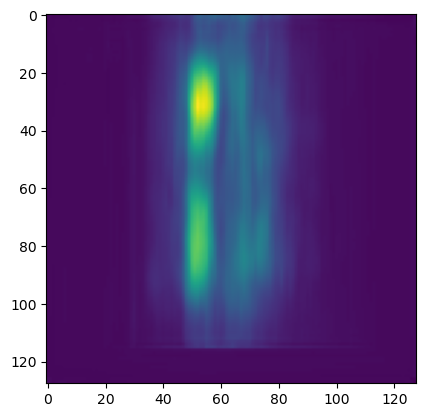

In [14]:
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(np.mean(mask[0,0,:,:,:].cpu().numpy(), axis=2))


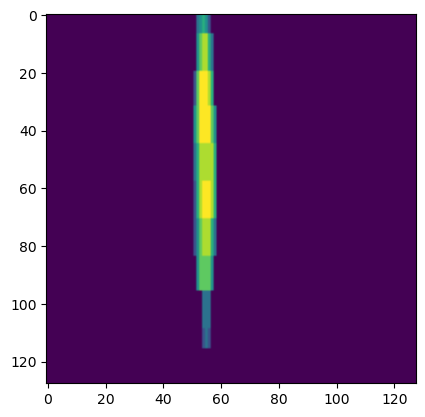

In [16]:
plt.imshow(np.mean(target_out_raw[0,0,:,:,:], axis=2))